In [47]:

!pip install scikit-learn xgboost lightgbm catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, recall_score, precision_recall_curve, accuracy_score

from xgboost import XGBClassifier

sns.set(style="whitegrid")


Load Dataset

In [53]:
train_path = "/content/drive/MyDrive/Eminance/Heart_Attack_training_dataset.csv"
test_path  = "/content/drive/MyDrive/Eminance/Hear_Attack_evaluation_dataset.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (7963, 26)
Test shape: (800, 25)


Split Target

In [54]:
y_train = train_df["heart_attack_risk"]
X_train = train_df.drop(columns=["heart_attack_risk", "patient_id"], errors="ignore")

test_ids = test_df["patient_id"]
X_test = test_df.drop(columns=["patient_id"], errors="ignore")

Feature Engineering

In [55]:
def add_features(df):
    """Add intelligent features"""
    # Split BP
    if 'bp' in df.columns:
        df[['systolic_bp','diastolic_bp']] = df['bp'].str.split('/', expand=True).astype(float)
        df.drop(columns=['bp'], inplace=True)

    # Cholesterol / BMI ratio
    if 'chol' in df.columns and 'bmi' in df.columns:
        df['chol_over_bmi'] = df['chol'] / (df['bmi'] + 1e-6)

    # Age x heart rate interaction
    if 'age' in df.columns and 'hr' in df.columns:
        df['age_hr_interaction'] = df['age'] * df['hr']

    # Exercise vs BMI fitness score
    if 'exercise_hr_wk' in df.columns and 'bmi' in df.columns:
        df['fitness_score'] = df['exercise_hr_wk'] / (df['bmi'] + 1e-6)

    return df

X_train = add_features(X_train)
X_test  = add_features(X_test)

Pre Processing

In [56]:
num_features = X_train.select_dtypes(include=["int64","float64"]).columns
cat_features = X_train.select_dtypes(include=["object","category"]).columns

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

Model

In [57]:
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

Train Validation Split

In [58]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

pipeline.fit(X_tr, y_tr)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:04:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'chol', 'hr', 'diabetes', 'family_history', 'smoking', 'obesity',
       'alcohol', 'exercise_hr_wk', 'prev_heart_prob', 'med_use', 'stress_lvl',
       'sedentary_hr', 'income', 'bmi', 'triglycerides', 'phys_act_days',
       'sleep_hr', 'systolic_bp', 'dias...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

Validation Check

In [59]:
y_val_proba = pipeline.predict_proba(X_val)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Find best threshold for max F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (max F1): {best_threshold:.2f} | F1: {f1_scores[best_idx]:.4f}")

Best Threshold (max F1): 0.11 | F1: 0.5142


Plotting

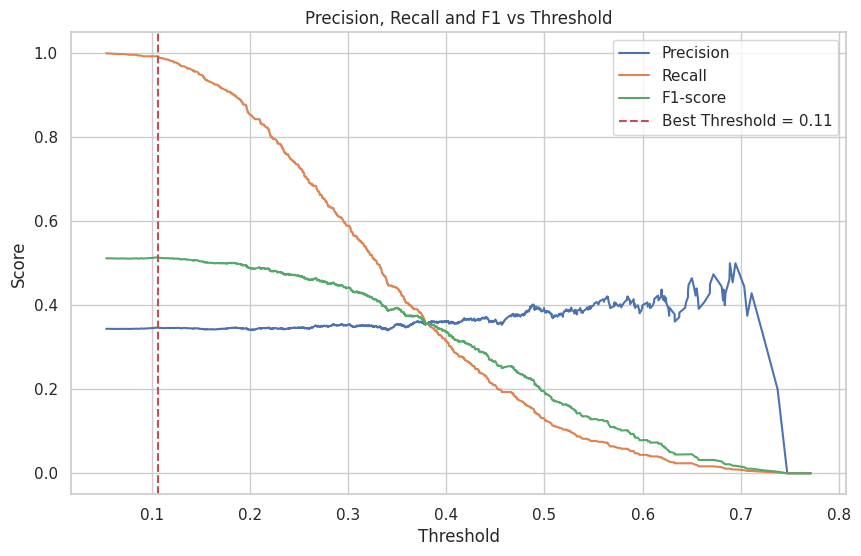

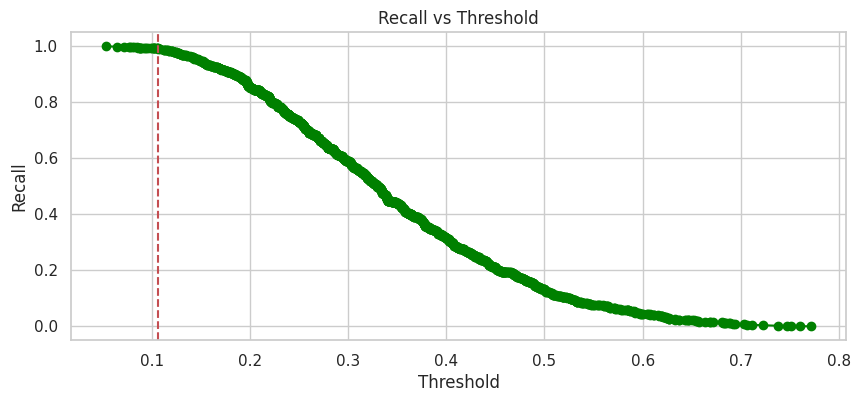

In [61]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 vs Threshold')
plt.legend()
plt.show()

# Plot Recall vs Threshold separately
plt.figure(figsize=(10,4))
plt.plot(thresholds, recalls[:-1], marker='o', color='green')
plt.axvline(best_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.show()


In [62]:
y_val_pred = (y_val_proba >= best_threshold).astype(int)
print("\nValidation Metrics at threshold", best_threshold)
print(classification_report(y_val, y_val_pred, digits=4))
print("Recall:", recall_score(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))


Validation Metrics at threshold 0.10624874
              precision    recall  f1-score   support

           0     0.8400    0.0201    0.0393      1045
           1     0.3469    0.9927    0.5142       548

    accuracy                         0.3547      1593
   macro avg     0.5935    0.5064    0.2767      1593
weighted avg     0.6704    0.3547    0.2026      1593

Recall: 0.9927007299270073
Accuracy: 0.354676710608914


Final Model Traning

In [63]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:04:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'chol', 'hr', 'diabetes', 'family_history', 'smoking', 'obesity',
       'alcohol', 'exercise_hr_wk', 'prev_heart_prob', 'med_use', 'stress_lvl',
       'sedentary_hr', 'income', 'bmi', 'triglycerides', 'phys_act_days',
       'sleep_hr', 'systolic_bp', 'dias...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

Predict on Test Data

In [64]:
y_test_proba = pipeline.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

submission = pd.DataFrame({
    "patient_id": test_ids,
    "heart_attack_risk": y_test_pred
})

submission.to_csv("/content/heart_attack_predictions.csv", index=False)
print("Submission saved: heart_attack_predictions.csv")

Submission saved: heart_attack_predictions.csv
